In [51]:
import os
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt
from collections import Counter

from tqdm import tqdm
import gc
import torch

# Analysis

In [26]:
class Gaussians:
    def __init__(self, folder: str):
        self.folder = folder
        self.files = self.get_files()
        self._index = 0 #For iterator
        
    def get_files(self):
        files = list(sorted(filter(lambda x: x.endswith(".ply"), os.listdir(self.folder))))
        return [os.path.join(self.folder, filename) for filename in files]
        
    @staticmethod
    def read_ply_file(file_path):
        plydata = PlyData.read(file_path)
        data = plydata['vertex'].data
        return data
    
    @staticmethod
    def extract_gaussian_attributes(data):
        attributes = {}
        attributes['positions'] = np.vstack((data['x'], data['y'], data['z'])).T
        attributes['normals'] = np.vstack((data['nx'], data['ny'], data['nz'])).T
        attributes['features_dc'] = np.vstack([data[name] for name in data.dtype.names if 'f_dc' in name]).T
        attributes['features_rest'] = np.vstack([data[name] for name in data.dtype.names if 'f_rest' in name]).T
        attributes['opacity'] = data['opacity']
        attributes['scale'] = np.vstack([data[name] for name in data.dtype.names if 'scale' in name]).T
        attributes['rotation'] = np.vstack([data[name] for name in data.dtype.names if 'rot' in name]).T
        return attributes
    
    @staticmethod
    def load_attributes(path: str):
        return Gaussians.extract_gaussian_attributes(Gaussians.read_ply_file(path))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        return Gaussians.load_attributes(self.files[idx])
    
    def __iter__(self):
        self._index = 0
        return self

    def __next__(self):
        if self._index < len(self):
            result = self[self._index]
            self._index += 1
            return result
        else:
            raise StopIteration
            
    def get_positions(self, idx: int, vertices: np.ndarray = None):
        positions = Gaussians.load_attributes(self.files[idx])["positions"]
        if vertices is not None:
            return positions[vertices]
        return positions
    
    def positions_differences(self) -> list:
        indices = list(range(len(self)))
        euclidean_differences = [] 
        for first, second in tqdm(zip(indices[:-1], indices[1:])):
            att_1 = self[first]
            att_2 = self[second]
            position_diff = (((att_2["positions"] - att_1["positions"]) ** 2).mean(axis=1) ** (1/2))
            euclidean_differences.append(position_diff)
        return euclidean_differences
    
    @staticmethod
    def summed_windowed_position_differences(position_differences: list, window=3) -> list:
        return [sum(position_differences[idx: idx + window]) for idx in range(len(position_differences) - window)]
    
    @staticmethod
    def outliers_per_window(summed_diffs: list, diff_norm: float = 10.0) -> list:
        return [diffs[diffs > diff_norm].shape[0] for diffs in summed_diffs]
    
    @staticmethod
    def get_outlier_vertices(summed_diffs: list, diff_norm: float = 10.0) -> np.ndarray:
        outliers_vertices = []
        for diffs in summed_diffs:
            outliers_vertices.append(np.where(diffs > diff_norm)[0])
        return np.array(outliers_vertices)

In [27]:
folder = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/"

In [28]:
gaussians = Gaussians(folder)

In [9]:
pos_diffs = gaussians.positions_differences()

200it [00:22,  8.81it/s]


In [10]:
summed_diffs_3 = Gaussians.summed_windowed_position_differences(pos_diffs, 3)

Let's try to understand if for some timestamps/threshold pairs we see some seemable change:

In [192]:
min_change_per_3_steps = 0.5

In [193]:
changes = Gaussians.outliers_per_window(summed_diffs_3, min_change_per_3_steps)

In [194]:
len(changes)

197

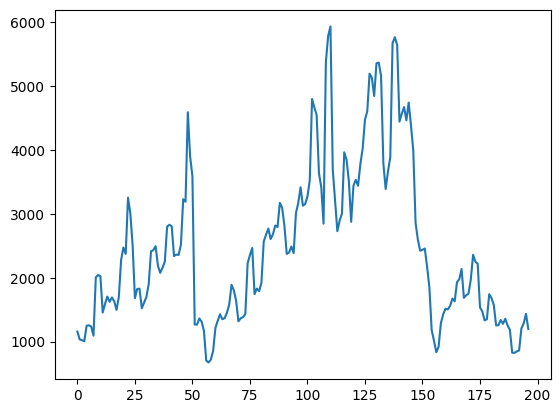

In [195]:
plt.plot(changes)

In [196]:
vertices = Gaussians.get_outlier_vertices(summed_diffs_3, min_change_per_3_steps)

/vol/isy-rl/dtrofimov/conda-isy/envs/Gaussians4D/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [132]:
np.savez("/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gs_most_moving.npz", v=vertices)

**For now we did:**
1. Calculated differences betwee Gaussians between timesteps
2. Summed them over the window of 3 timestamps to find big changes
3. Thresholded them to try to highlight Gaussians that changed the most in each timeframe

**Now let's try to:**
1. Find the moment where the biggest number of Gaussians changed their positions
2. Take these vertices and their positions
3. Cluster them with some algorithm to get 1 cluster of Gaussians for the door

## DBSCAN

In [197]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [198]:
frame_with_max_changes = np.argmax(changes)
print(f"Frame with the most changes in Gaussians: {frame_with_max_changes}")

Frame with the most changes in Gaussians: 110


In [199]:
vertices[frame_with_max_changes].shape

(5929,)

In [200]:
gaussians_for_clustering = gaussians.get_positions(frame_with_max_changes, vertices[frame_with_max_changes])

In [202]:
gaussians_for_clustering.shape

(5929, 3)

In [203]:
min_samples = 50

In [204]:
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(gaussians_for_clustering)
distances, indices = nbrs.kneighbors(gaussians_for_clustering)

k_distances = distances[:, min_samples-1]
k_distances = np.sort(k_distances)

In [206]:
k_distances[5000]

2.9599858464653814

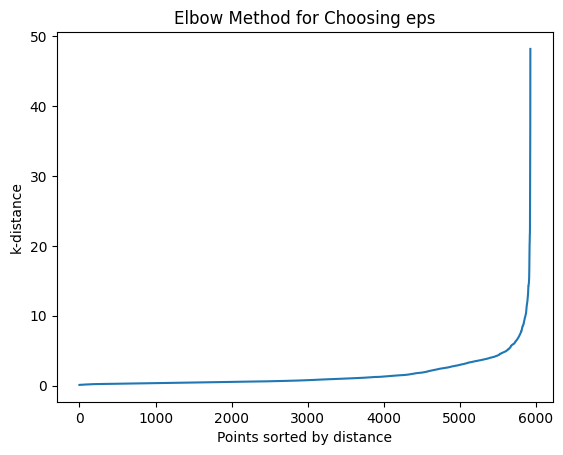

In [207]:
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('Elbow Method for Choosing eps')
plt.show()

In [208]:
clustering = DBSCAN(eps=0.30, min_samples=50).fit(gaussians_for_clustering)

In [209]:
def biggest_cluster(clustering):
    cnt = Counter(clustering.labels_)
    del cnt[-1]
    cnt = sorted(cnt.items(), key=lambda x: x[1], reverse=True)[0]
    return cnt

In [210]:
cluster = biggest_cluster(clustering)

In [211]:
cluster

(3, 465)

In [213]:
Counter(clustering.labels_)

Counter({-1: 4691,
         5: 91,
         3: 465,
         0: 143,
         1: 172,
         2: 63,
         4: 63,
         8: 80,
         7: 79,
         6: 82})

In [214]:
vertices[frame_with_max_changes][clustering.labels_ == cluster[0]].shape

(465,)

In [216]:
np.savez("/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gs_clustered.npz",
         v=np.tile(vertices[frame_with_max_changes][clustering.labels_ == cluster[0]].reshape(1, -1), (380, 1)))